

predict arrest outcome

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso

In [2]:
#load data
df = pd.read_csv('data/cleaned_df.csv')

#change frisk and arrest flags to 1 and 0
df.replace({'Frisk_Flag' : { 'Y' : 1, 'N' : 0}}, inplace=True)
df.replace({'Arrest_Flag' : { 'Y' : 1, 'N' : 0}}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject_Age_Group         52147 non-null  object
 1   Was_Weapon_Reported       52147 non-null  object
 2   Officer_Gender            52147 non-null  object
 3   Officer_Race              52147 non-null  object
 4   Subject_Perceived_Race    52147 non-null  object
 5   Subject_Perceived_Gender  52147 non-null  object
 6   Arrest_Flag               52147 non-null  int64 
 7   Frisk_Flag                52147 non-null  int64 
 8   Officer_Age               52147 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 3.6+ MB


## Preprocessing Data

First the non-numeric variables need to be split into data types that can be properly interpreted by our classifiers.


In [3]:
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 27 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   Arrest_Flag                                                       52147 non-null  int64
 1   Frisk_Flag                                                        52147 non-null  int64
 2   Officer_Age                                                       52147 non-null  int64
 3   Subject_Age_Group_1 - 17                                          52147 non-null  uint8
 4   Subject_Age_Group_18 - 25                                         52147 non-null  uint8
 5   Subject_Age_Group_26 - 35                                         52147 non-null  uint8
 6   Subject_Age_Group_36 - 45                                         52147 non-null  uint8
 7   Subject_Age_Group_46 - 55                        

### Splitting Data

Now we separate the data into train and test sets, and scale the features so that our algorithms can properly interpret them.

In [4]:
#separate arrest outcome and train test split

X= dummies_df.drop('Arrest_Flag', axis=1)
y = dummies_df['Arrest_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Scale numerical data

In [5]:
#scale data (only numerical training data features, not target)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(data = scaler.transform(X_train), columns = X.columns)
# the testing dat
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X.columns)

### Baseline Model

We start with a baseline Logistic Regression Model.

In [6]:
def plot_ROC(clf):
    # Probability scores for test set
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    # False positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    # Seaborn's beautiful styling
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    # Print AUC
    print('AUC: {}'.format(auc(fpr, tpr)))

    # Plot the ROC curve
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
def plot_confusion(clf):
    plot_confusion_matrix(clf, X_test, y_test, display_labels=["No Arrest", "Arrest"], 
                     cmap='Blues')
    plt.grid(False) # removes the annoying grid lines from plot
    plt.show()

In [7]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)

log_f1 = metrics.f1_score(y_test, pred)
log_acc = metrics.accuracy_score(y_test, pred)

print('F1:', log_f1)

F1: 0.0


AUC: 0.6480420849506267


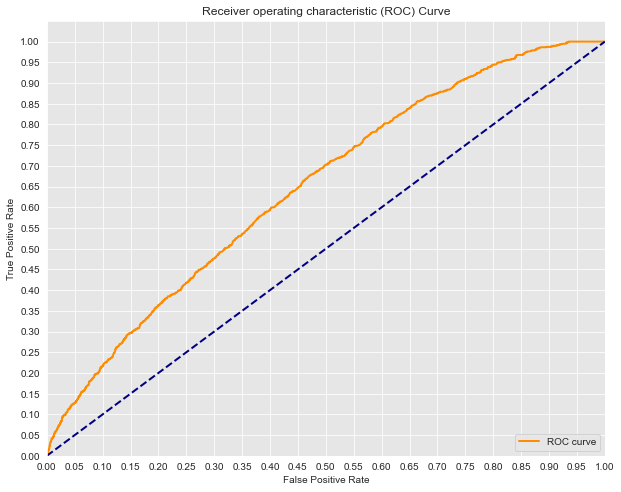

C:\Users\moola\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


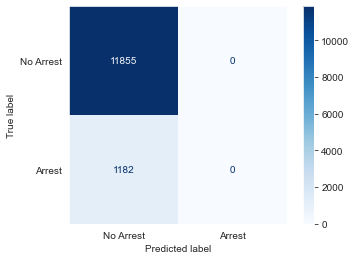

In [8]:
plot_ROC(logreg)

plot_confusion(logreg)

This does not yield fantastic results at all. 

Additionally, the ROC curve doesnt express valuable data because of how imbalanced the data is (which we will solve shortly). 

### Feature Selection
Now we will use Lasso Regression to regularize our data, in order to remove the least significant features to the dataset.

In [25]:
lasso = Lasso(alpha = .001)
lasso = lasso.fit(X_train, y_train)
y_train_predFS = lasso.predict(X_train)
# y_test_pred_fs = lasso.predict(X_test_fs)

In [26]:
lasso.coef_

array([ 0.04382768, -0.05521205, -0.0210653 ,  0.03942433,  0.04121724,
        0.01854654,  0.01523577,  0.02582731,  0.01786142,  0.01180493,
       -0.01798109,  0.01754791,  0.00709412,  0.01554952, -0.08161218,
       -0.05070461,  0.01181253, -0.00335933,  0.01122193, -0.03126642])

<AxesSubplot:title={'center':'Modal Coefficients'}>

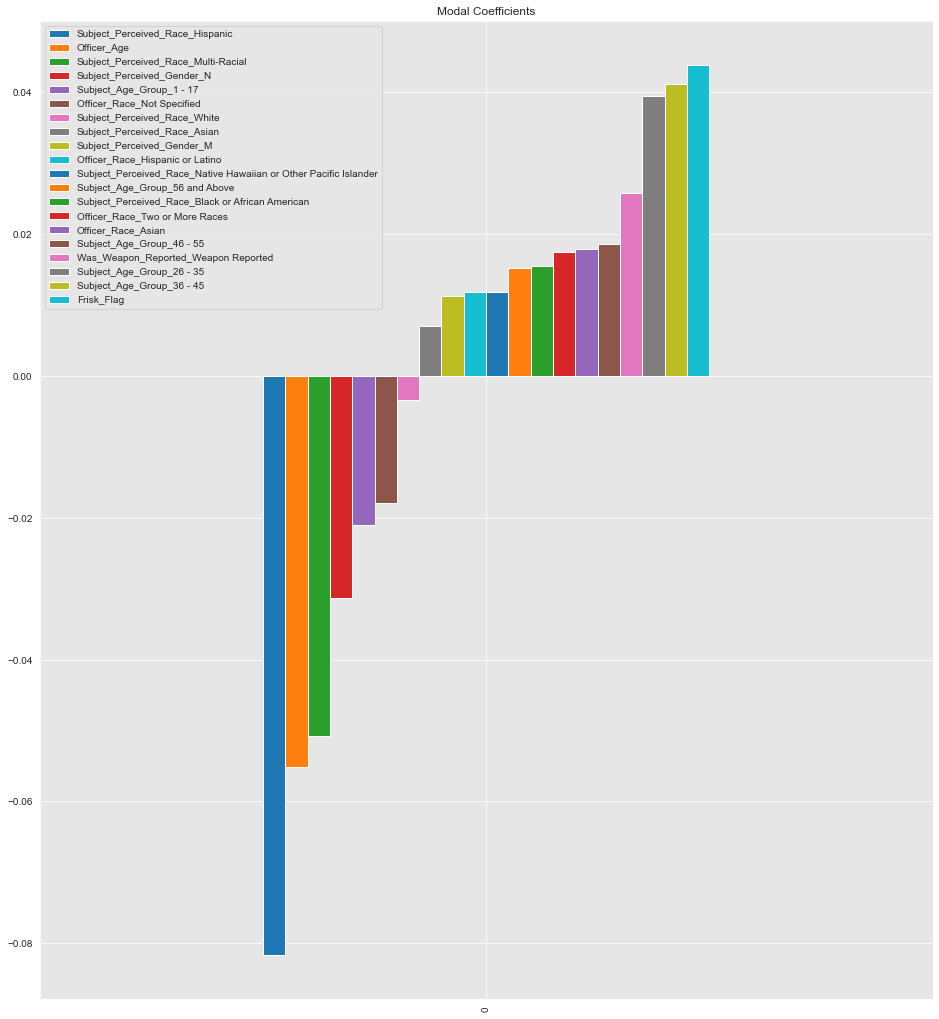

In [27]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = X_train.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T
lasso_coef.plot(kind='bar', title='Modal Coefficients', legend=True, figsize=(16,18))

In [28]:
lasso_coef.T

,0
Subject_Perceived_Race_Hispanic,-0.081612
Officer_Age,-0.055212
Subject_Perceived_Race_Multi-Racial,-0.050705
Subject_Perceived_Gender_N,-0.031266
Subject_Age_Group_1 - 17,-0.021065
Officer_Race_Not Specified,-0.017981
Subject_Perceived_Race_White,-0.003359
Subject_Perceived_Race_Asian,0.007094
Subject_Perceived_Gender_M,0.011222
Officer_Race_Hispanic or Latino,0.011805


In [29]:
#remove features with 0


lasso_features = ['Subject_Perceived_Race_Unknown', 'Officer_Race_White', 'Officer_Gender_M', 'Officer_Race_Black or African American', 
                  'Officer_Race_Nat Hawaiian/Oth Pac Islander', 'Subject_Age_Group_18 - 25']


X_train.drop(lasso_features, axis=1, inplace=True)
X_test.drop(lasso_features, axis=1, inplace=True)

X_train.info()

KeyError: "['Subject_Perceived_Race_Unknown' 'Officer_Race_White' 'Officer_Gender_M'\n 'Officer_Race_Black or African American'\n 'Officer_Race_Nat Hawaiian/Oth Pac Islander' 'Subject_Age_Group_18 - 25'] not found in axis"

### Class Imbalance
The current assortment of target values is greatly imbalanced, so we will also use SMOTE to create synthetic data.

In [30]:
#show imbalance of arrest flags

y_train.value_counts()

0    35563
1    35563
Name: Arrest_Flag, dtype: int64

In [31]:
smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

0    35563
1    35563
Name: Arrest_Flag, dtype: int64

## Now we test various classifiers. 

#talk about evaluation scores! list all, choose most important

#using f1 but also observing confusion matrix and roc/auc when necessary.

In this analysis, we will test Logistic Regression, KNN, Decision Trees, Random Forest, and XGBoost

#### #@!$@!WFAGASG DO NOT USE THIS!

Modeling
The Evaluation metric we are using is F1 score, because we want both precision and recall.

Our model is very imbalanced towards no arrests, and as such will want to follow patterns:

If our model were to have high precision, but low recall, it would be good at making CORRECT predictions of not getting arrested, but may miss a lot of cases where there are no arrests. (True positives out of predicted positives)

If our model were to have low precision, but high recall, it could simply classify everyone as not getting arrested and score very high. (True positives out of actual total positives)

If our model were to be scaled on accuracy, it could get high score by simply predicting no arrests similar to recall.

We want to predict the correctly predict arrests overall, as we want to determine what features may give bias for arrests.

HJAFNLKJSFAKLJPIRJ@PI#J!PIJ$%OJPI(JM:M
#### ############

In [32]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)

log_f1 = metrics.f1_score(y_test, pred)
log_acc = metrics.accuracy_score(y_test, pred)

print('F1:', log_f1)

F1: 0.2120181405895692


AUC: 0.6441324992274815


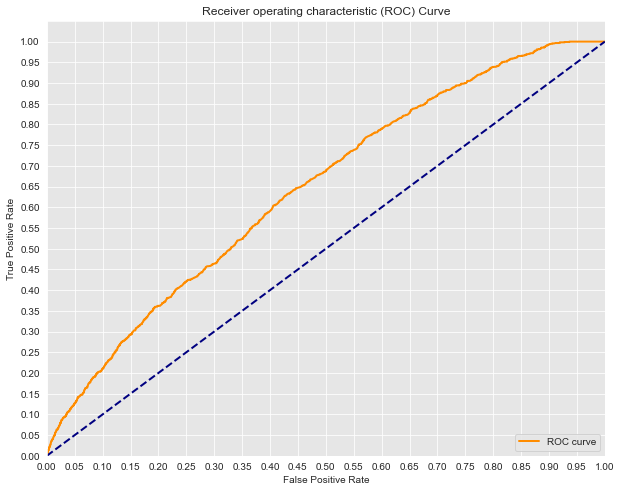

C:\Users\moola\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


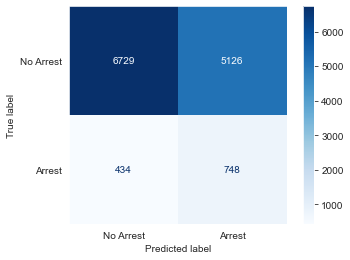

In [33]:
plot_ROC(logreg)

plot_confusion(logreg)

### Tuning Parameters
These results have the potential to be adjsuted by finidng the ideal parameters for the classifier, using GridSearchCV.

In [50]:
# logistic regression params

clf = LogisticRegression(random_state=42)

## CHANGE THIS TO UNIQUE IDENTIFIER (NOT CLF)

logreg_param_grid = {
    
    'C': [100, 10, 1.0, 0.1, 0.01]
    ## ETC ETC ETC
}

gsCV = GridSearchCV(clf, logreg_param_grid, cv=3)
gsCV.fit(X_train, y_train)

gsCV.best_params_

{'C': 10}

In [52]:
pred = gsCV.predict(X_test)

log_f1 = metrics.f1_score(y_test, pred)
log_acc = metrics.accuracy_score(y_test, pred)

print('F1:', log_f1)

F1: 0.21192803513245503


AUC: 0.6441506257577996


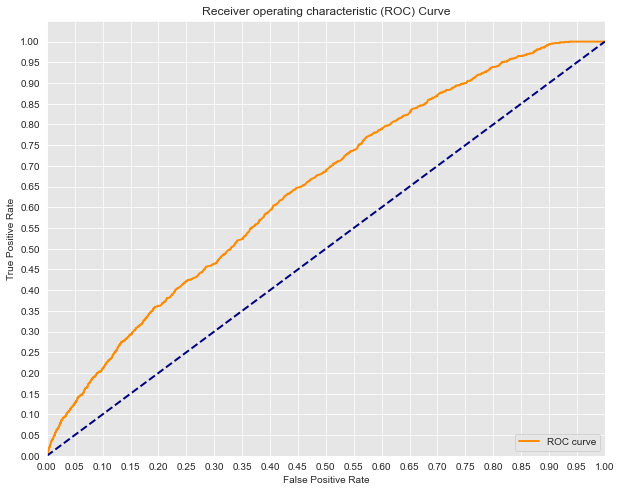

C:\Users\moola\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


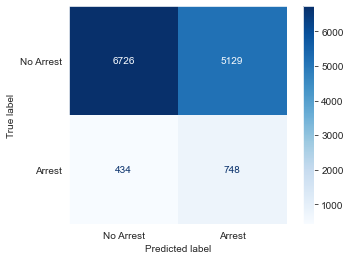

In [53]:
plot_ROC(gsCV)

plot_confusion(gsCV)

In [ ]:
### NOTE LITTLE DIFFERENCE< REPEAT WITH EACH CLF

In [35]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

knn_f1 = metrics.f1_score(y_test, pred)

print('F1:', knn_f1)

F1: 0.14900947459086994


C:\Users\moola\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


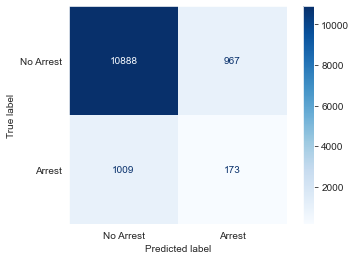

In [37]:
plot_confusion(knn)

In [21]:
dectree = DecisionTreeClassifier(max_depth=3)
dectree.fit(X_train, y_train)
pred = dtree.predict(X_test)

dectree_f1 = metrics.f1_score(y_test, pred)

print('F1:', dectree_f1)

F1: 0.18972922502334266


In [22]:
forest = RandomForestClassifier(max_depth=3)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)

forest_f1 = metrics.f1_score(y_test, pred)

print('F1:', forest_f1)

F1: 0.21030042918454936


In [23]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

xgb_f1 = metrics.f1_score(y_test, pred)

print('F1:', xgb_f1)

[20:20:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\moola\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1: 0.165408598621595


Now we run ournew data through a model pipeline.

In [24]:
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['classifier'] = [clf6]

param7 = {}
param7['classifier__n_estimators'] = [10, 50, 100, 250]
param7['classifier__max_depth'] = [5, 10, 20]
param7['classifier'] = [clf7]

NameError: name 'clf1' is not defined

In [ ]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3, param4, param5, param6, param7]

In [ ]:
cv.best_params_

In [ ]:
#predict on the test set
y_pred = cv.predict(X_test)

#capture the prediction probabilities
y_predict_proba = cv.predict_proba(X_test)[:,1]

In [ ]:
#scoring metrics
acc_score = cv.score(X_test, y_test)

print('The accuracy score is: {}'.format(acc_score))


#print the confusion matrix and classification report from the best model
print(confusion_matrix(y_test, y_pred))